In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import julian
import datetime
import time

%pylab inline
from dtw import dtw
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import statsmodels.api as sm

from os import listdir
from os.path import isfile, join

Populating the interactive namespace from numpy and matplotlib


In [2]:

# path to the solar data
path = 'C:\\Users\\Ian Joyce\\Desktop\\R\\daily_data\\'

# pull all of the file names and store them in a list
file_names = [f for f in listdir(path) if isfile(join(path, f))]



# load the first day 2008-01-01
data = np.loadtxt(path + file_names[0],
                     delimiter='     ',
                     skiprows=2, 
                     usecols=[0,3], 
                     dtype=str)

# use vstack to append all other days to the first
for i in file_names[1:]:
    #print(i)
    data = vstack((data, 
                  np.loadtxt(path + str(i),
                     delimiter='     ',
                     skiprows=2, 
                     usecols=[0,3], 
                     dtype=str)))
    

data
    

array([['  39447.61273', ' 0.08317'],
       ['  39447.61296', ' 0.08388'],
       ['  39447.61319', ' 0.08458'],
       ...,
       ['  39812.93356', ' 0.08165'],
       ['  39812.93380', ' 0.08098'],
       ['  39812.93403', ' 0.08032']], dtype='<U13')

In [3]:
# clean the data and convert to pandas df to use built in functions

# clean the data
i = 0
for i in range(0,len(data)):
    data[i,0] = data[i,0][2:]
    data[i,1] = data[i,1][1:]


# convert the string to a float
data = data.astype(np.float)

# shfit the data to make DTW algorithm run faster
data[:,1]  = data[:,1] *100000

# convert the data into a df to use pandas packages
data = pd.DataFrame(data)

# rename columns to give the data its original header
data = data.rename(index=str, columns={0: "v1", 1: "v4"})
data.head()



,v1,v4
0,39447.61273,8317.0
1,39447.61296,8388.0
2,39447.61319,8458.0
3,39447.61343,8491.0
4,39447.61366,8563.0


In [10]:

'''
Convert Julian Date Time to Georgian
'''


# convert julian datetime to georgian and is stored in a separate dataframe called time
# shift julian time to current time, the original time by adding 2415018.88773 
# brings the julian date to 2008-01-01 which is the actual date

# shift the time 
dft = data['v1'] + 2415018.88773

# create a list to store the converted times
cdt = [] # converted date time

for i in range(0,len(dft)):   
    cdt.append(julian.from_jd(dft[i]))
    
    
# round the time to represent the 20 second intervals that the data was sampled
def roundTime(dt=None, roundTo=60):
   """Round a datetime object to any time laps in seconds
   dt : datetime.datetime object, default now.
   roundTo : Closest number of seconds to round to, default 1 minute.
   Author: Thierry Husson 2012 - Use it as you want but don't blame me.
   """
   if dt == None : dt = datetime.datetime.now()
   seconds = (dt.replace(tzinfo=None) - dt.min).seconds
   rounding = (seconds+roundTo/2) // roundTo * roundTo
   return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)

# create a new list to store the rounded time
ncdt = []

# round all of the times
for i in range(0,len(cdt)):   
    ncdt.append(roundTime(cdt[i],roundTo = 10))
    
    
# convert the list into a pandas data frame to 
# converting directly to numpy results in a poorly formatted output
time = pd.DataFrame(ncdt)
cdtheader = ['time']
time.columns = cdtheader 


In [11]:
time.head()

,time
0,2008-01-01 00:00:40
1,2008-01-01 00:01:00
2,2008-01-01 00:01:20
3,2008-01-01 00:01:40
4,2008-01-01 00:02:00


In [12]:
time.tail()

,time
668567,2008-12-31 07:42:00
668568,2008-12-31 07:42:20
668569,2008-12-31 07:42:40
668570,2008-12-31 07:43:00
668571,2008-12-31 07:43:20


In [4]:
'''
Generate Synthetic Features 
'''

# create empty columns to store results

data['dist'] = np.nan
data['pred_180'] = np.nan
data['act_180'] = np.nan
data['model_error'] = np.nan
data['pred_ind'] = np.nan

# generate roling mean and standard deviation synthetic features

data['mu60'] = data['v4'].rolling(60).mean()
data['sig60'] =   data['v4'].rolling(60).std() 

data['mu180'] = data['v4'].rolling(180).mean()
data['sig180'] =   data['v4'].rolling(180).std() 


# generate ols synthetic feature
data['intercept'] = np.nan
data['slope'] = np.nan



In [5]:
# convert data to numpy to increase speed on computing OLS and DTW
d = np.array(data)


# Running OLS on a one hour time period
window=180
X = range(0,window)
X = sm.add_constant(X)

# rolling ols as a synthetic feature
for i in range(0,668572-180):
    Y = list(d[i:(i+180),1]) # convert to list, the desired format for statsmod


    model = sm.OLS(Y,X)
    results = model.fit()
    
    d[i+180,11] = results.params[0] # store intercept
    d[i+180,12]  = results.params[1] # store slope
    
    

In [6]:
# Add an index to column 13
d = np.insert(d, 13, np.nan, axis=1)
for i in range(0,668572):
    d[i,13] = i

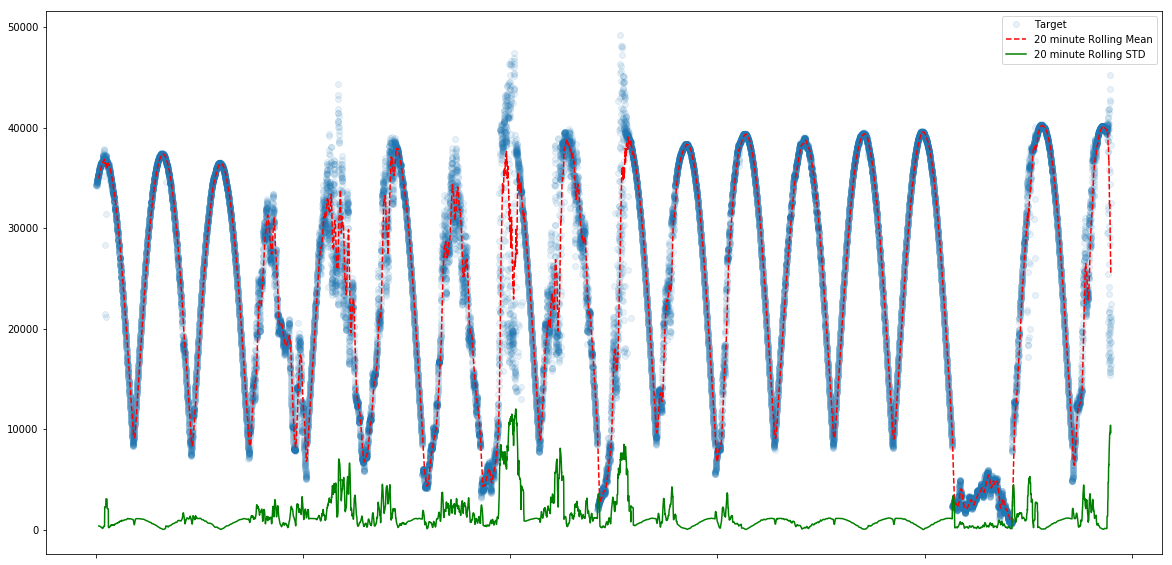

In [8]:
'''
Visualize Data and Synthetic Features
'''

data['v4'].iloc[500:25000].plot(label = 'Target' , style='o', alpha = 0.1, figsize=(20,10))
data['v4'].iloc[500:25000].rolling(60).mean().plot(label = '20 minute Rolling Mean',style = 'r--', figsize=(20,10))
data['v4'].iloc[500:25000].rolling(60).std().plot(label= '20 minute Rolling STD',style = 'g',figsize=(20,10))

plt.legend()

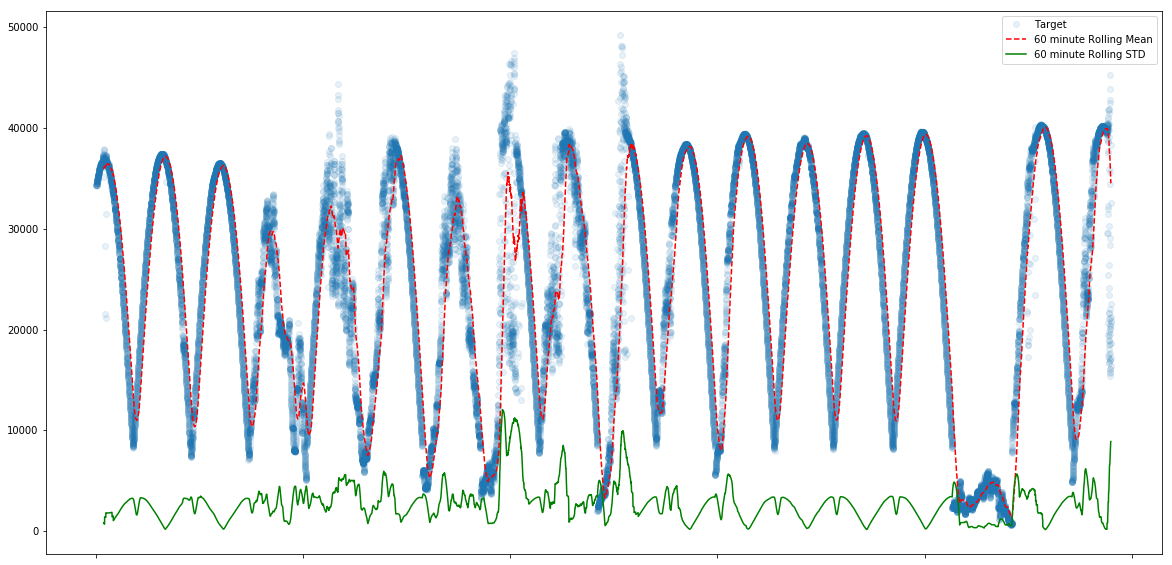

In [9]:
data['v4'].iloc[500:25000].plot(label = 'Target' , style='o', alpha = 0.1, figsize=(20,10))
data['v4'].iloc[500:25000].rolling(180).mean().plot(label = '60 minute Rolling Mean',style = 'r--', figsize=(20,10))
data['v4'].iloc[500:25000].rolling(180).std().plot(label= '60 minute Rolling STD',style = 'g',figsize=(20,10))

plt.legend()

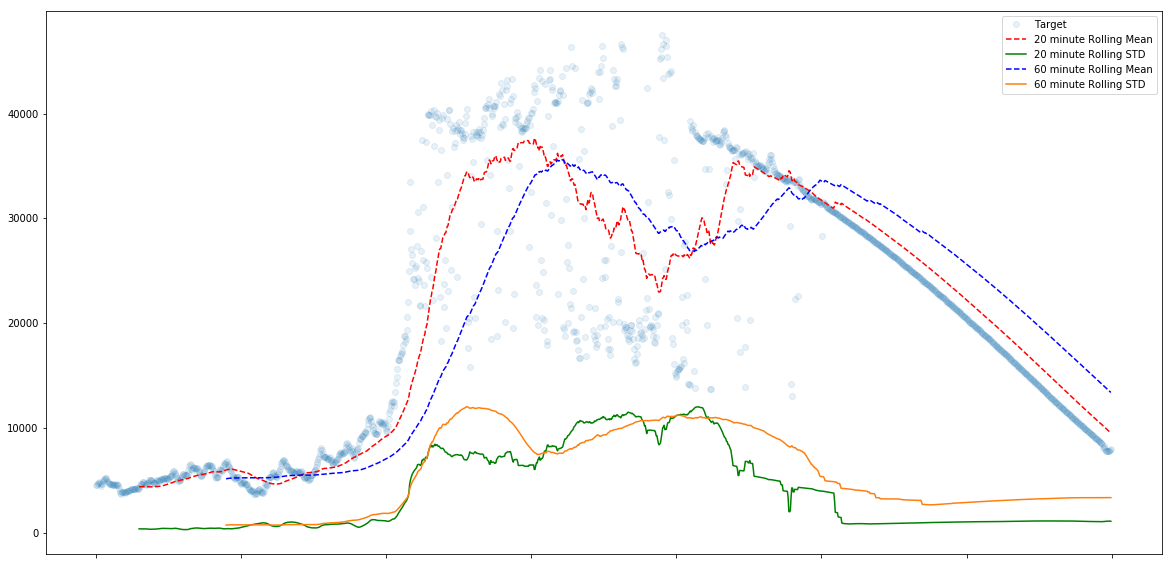

In [10]:
data['v4'].iloc[9800:11200].plot(label = 'Target' , style='o', alpha = 0.1, figsize=(20,10))

data['v4'].iloc[9800:11200].rolling(60).mean().plot(label = '20 minute Rolling Mean',style = 'r--', figsize=(20,10))
data['v4'].iloc[9800:11200].rolling(60).std().plot(label= '20 minute Rolling STD',style = 'g',figsize=(20,10))
data['v4'].iloc[9800:11200].rolling(180).mean().plot(label = '60 minute Rolling Mean',style = 'b--', figsize=(20,10))
data['v4'].iloc[9800:11200].rolling(180).std().plot(label= '60 minute Rolling STD',figsize=(20,10))

plt.legend()

Prediction Algorithm

First find ~30 nearest neighbors of the time series based of synthetic features
Second run DTW alg on the ~30 NN to find the 1 NN and make a one hour ahead prediction

0: v1: Time in julian             
1: v4: Target                
2: dist: fastDTW distance              
3: pred_180: One Hour ahead prediction                
4: act_180: One hour ahead ground truth                
5: model_error: Model error            
6: pred_ind: The index chosen by the minimum distance to make the prediction               
7: mu60: rolling 20 minute mean                   
8: sig60: rollin  20 minute STD              
9: mu180: rolling 60 minute mean                   
10: sig180: rollin  60 minute STD                 
11: intercept: rolling 60 minute OLS intercept             
12: slope: rolling 60 minute OLS           
13: index
'''

In [11]:
# define the min/max values to calibrate the search algorithm    
max_mu60 = max(d[180:,7])
max_sig60 = max(d[180:,8])
max_mu180 = max(d[180:,9])
max_sig180 = max(d[180:,10])

min_mu60 = min(d[180:,7])
min_sig60 = min(d[180:,8])
min_mu180 = min(d[180:,9])
min_sig180 = min(d[180:,10])

#slope and intercept are shifted to only have positive values
d[180:,11] = d[180:,11] - min(d[180:,11])
d[180:,12] = d[180:,12] - min(d[180:,12])



In [ ]:

# begin prediction 

for index in range(2926,10000):
    # Select the startpoint
    
    # find the synthetic features at that point in time
    mu60  = d[index,7]
    sig60 = d[index,8]
    mu180  = d[index,9]
    sig180 = d[index,10]
    intercept = d[index,11]
    slope  = d[index,12]
    
    
##########################################################

# decision function to determine which information to look at
# the while loop will increment until the ~30 nearest neighbors are found based off of synthetic features
# Important note: this will include the time interval being predicted, but will be excluded later
    
    # create an empty list to store ~30 NN
    select_rows =[]
    
    i = 0
    
    while len(select_rows) <= 30:
        select_rows = d[181:,13][

                ( d[181:,12] < slope + slope*(.001 + i)) &
                ( d[181:,12] > slope - slope*(.001 + i)) &
                ( d[181:,11] > intercept - intercept*(.001 + i)) &
                ( d[181:,11] < intercept + intercept*(.001 + i)) &
                ( d[181:,10] > sig180 - min_sig180*(.01 + i)) &
                ( d[181:,10] < sig180 + max_sig180*(.01 + i)) &
                ( d[181:,9] > mu180 -  min_mu180*(.01 + i) ) &
                ( d[181:,9] < mu180 +  max_mu180*(.01 + i) ) &  
                ( d[181:,8] > sig60 - min_sig60*(.001 + i)) &
                ( d[181:,8] < sig60 + max_sig60*(.001 + i)) &  
                ( d[181:,7] > mu60 -  min_mu60*(.01 + i) ) &
                ( d[181,7] < mu60 +  max_mu60*(.01 + i) )                  
                                 ]
        i = i + .001
        #print(i, len(select_rows))




    # run dynamic time warping on the ~ 30 NN to find the 1 NN based of the previous hour DTW distance

    
    # create an empty list to store the the DTW distance and the index it was predicted on
    l = [] 
    
    #loop through the selected rows to run DTW on the historical values to predict future values
    # if statement to verify that the same time is not used
    
    y = d[index-80:index,1].reshape(-1, 1) # find the target's one hour previous values
    
    for i in select_rows:
        
        # excludes two hours prior and after the selected time
        if i >= index + 360 or i <= index - 360: 

            x = d[int(i)-80:int(i),1].reshape(-1, 1) # look one hour behind 
            distance, path = fastdtw(x, y, dist=euclidean) # run fastDTW to find 1 NN
            l.append((distance,int(i) ))
        

        # prints the time's index. Verifies that the search algorithm found itself and did not use it for prediction
        #else:
            #print(i)
    
    # finds the 1 NN by finding the minimum DTW distance and it's prediction index
    min_dist, pred_index = min(l)
    
    # Make the prediction and find the ground truth
    prediction = d[pred_index:pred_index+180,1].reshape(-1, 1)
    traget = d[index:index+ 180,1].reshape(-1, 1)
    
    #print( sum(prediction), sum(traget), min_dist , index, pred_index)
    
    
    # stores the minimum DTW distance, the prediction, the actual, and the prediction index
    d[index,2] = min_dist
    d[index,3] = sum(prediction)
    d[index,4] = sum(traget)
    d[index,6] = pred_index
    
    #print(index, pred_index )

In [80]:
index

2926

In [83]:
# the ratio of the prediction to the ground truth

print( 'The average of the ratio of the prediction over the targer = '
      + str(sum((d[2000:index,3] / d[2000:index,4]))/ len((d[2000:index,3]))))

The average of the ratio of the prediction over the targer = 0.9965667483870971


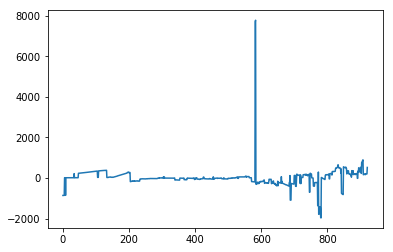

In [69]:
# the ratio of the prediction to the ground truth ploted over the predictions

plot(((d[2000:index,3] - d[2000:index,4])) / len((d[2000:index,3])))

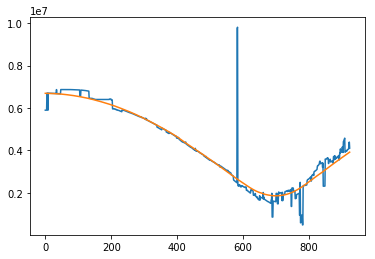

In [77]:
# Plot the predictions over the targets

plot(d[2000:index,3])
plot(d[2000:index,4])

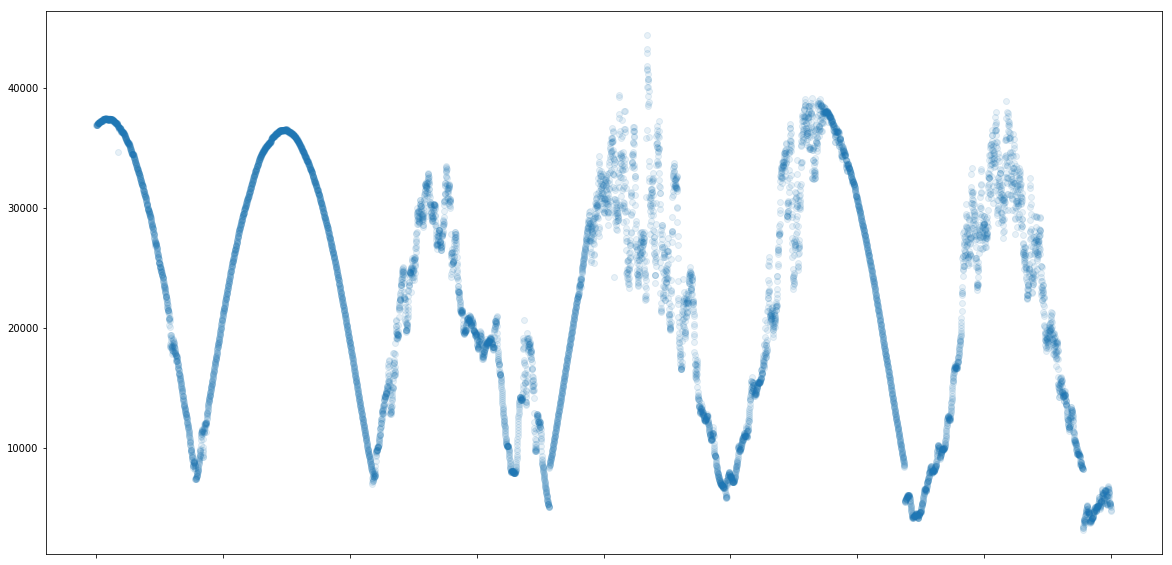

In [74]:
data['v4'].iloc[2000:10000].plot(label = 'Target' , style='o', alpha = 0.1, figsize=(20,10))
#data['v4'].iloc[523088:525088].plot(label = 'Target' , style='r--', figsize=(20,10))


In [72]:
# Save Results
np.savetxt("C:\\Users\\Ian Joyce\\Desktop\\code\\fastDTW results.csv", d, delimiter=",")